In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import numpy  as np
import matplotlib.pyplot as plt
import skimage.io
from scipy.io import loadmat
import numpy as np

from saliency import utils
from saliency.model import  IttyKoch
from saliency.data import load_video

# 2.2 Sequential Fixation Trajectories

In [2]:
video_id = 1

X, y = load_video(video_id)
X.shape, y.shape

((300, 576, 720, 3), (2, 300, 19))

Load pre-computed model outputs from Deep Gaze II and ICF

In [3]:
import h5py

with h5py.File('/home/stes/media/saliency/icf-compressed.hdf5', 'r') as ds:
    S_icf = ds[str(video_id)][...,0]

with h5py.File('/home/stes/media/saliency/deepgaze-compressed.hdf5', 'r') as ds:
    S_deep = ds[str(video_id)][...,0]
    
with h5py.File('/home/stes/media/saliency/ittykoch.hdf5', 'r') as ds:
    S_ittykoch = ds[str(video_id)][...]
    
S_icf.shape, S_deep.shape, S_ittykoch.shape

((300, 576, 720), (300, 576, 720), (300, 64, 80))

#### Compute human fixation average
Given the human fixation data each frame of the video,
compute the median, mean and standard deviation of the gaze fixations.

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/usr/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


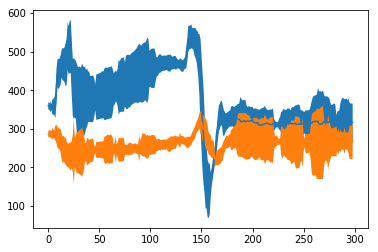

In [4]:
mean   = np.nanmean(y, axis=-1)
median = np.nanmedian(y, axis=-1)
std    = np.nanstd(y, axis=-1)

t = np.arange(len(mean.T))

plt.plot(t, median.T)
plt.fill_between(t, median[0]-std[0], median[0] + std[0])
plt.fill_between(t, median[1]-std[1], median[1] + std[1])
plt.show()

In [5]:
didc = slice(0,-1)
idc = slice(1,None)

diff = lambda x : np.exp(x[idc]) * abs(np.exp(x[idc])-np.exp(x[didc]))

dS_ittykoch = diff(S_ittykoch)
dS_icf      = diff(S_icf)
dS_deep     = diff(S_deep)

In [6]:
S_all = (sum(s for s in [dS_icf, dS_deep]))

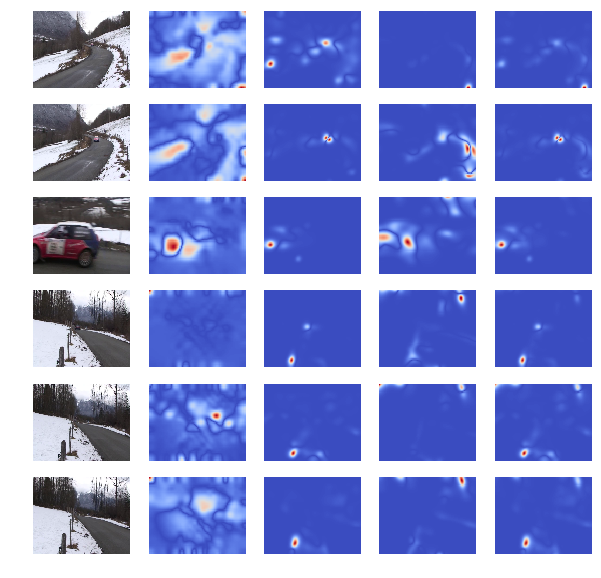

In [9]:
from saliency import  saliency

didc = slice(50+39,-41,30)
idc = slice(50+40,-40,30)

n_examples = len(X[idc])

fig, axes = plt.subplots(n_examples,5,figsize=(10,10))

for ax, imgs in zip(axes, zip(X[idc], dS_ittykoch[idc], dS_deep[idc], dS_icf[idc], S_all[idc])):
    for a, i in zip(ax,imgs):
        a.imshow(i, cmap="coolwarm")
        a.grid("off")
        a.axis("off")
plt.savefig("report/fig/car.pdf", bbox_inches="tight")

#### Test the current saliency model with the video

Use the code implemented in block 1 to test
the saliency response on the video. Be aware that due to the dynamics of the image we
cannot properly implement a fixation strategy like the inhibition of return developed in the
previous section.

In [26]:
S_all_log = np.log(1e-2+S_all)

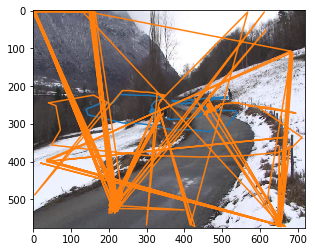

In [54]:
yy, xx = utils.argmax2d(S_all_log)

plt.imshow(X[0])
plt.plot(median[0], median[1])
plt.plot(xx,yy)

Text(0.5,1,'Fixation Strategy')

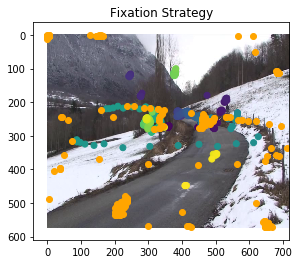

In [56]:
t = np.arange(y.shape[1])
plt.imshow(X[100])
plt.scatter(y[0,:,0], y[1,:,0], c=t) #, s=10*(std[0]**2+std[1]**2)**.5, c=t)
plt.scatter(xx,yy,color="orange")
plt.title("Fixation Strategy")

### Evaluation

we will use two objective measures to evaluate the performance of the model:
the mean squared error from the average human fixation trajectory and NSS.

#### Median squared error

Given the human gaze fixation data median, $\mu' = (i, j)$ in
pixels coordinates, and the maximum salient response $\hat{\mu}$ from the model we
compute the total error of all frames $N$ as:

$$
\text{MSE}(\hat{\mu}, \mu') = \frac{1}{N} \sum_{i = 1}^N (\hat{\mu}_i - \mu'_i)^2
$$


#### NSS

Given a binary map of fixation locations F (human data) and the saliency map S
(response from the model), the NSS measure is computed as:

$$
\text{NSS}(S,F) = \frac{1}{N} \sum_{i = 1}^N \overline{S}_i \times F_i
$$

Where $N = \sum_i F_i$ is the total number of fixated pixels and $\overline{S} = \frac{S - \mu(S)}{\sigma(S)}$ is the normalized saliency map.
A value of 0 means means that it is chance (i.e., random), positive values shows correspondence and
negative values anti-correspondence.

/home/stes/sciebo/Privat/uni/msc/msne/semester_3/nise/saliency/saliency/utils.py:53: RuntimeWarning: Mean of empty slice
  nss_score = np.nanmean(nss_score, axis=1)


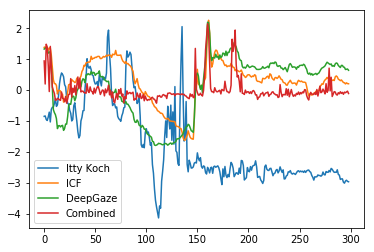

In [36]:
for s, t in zip([S_ittykoch, S_icf, S_deep, S_all], ["Itty Koch", "ICF", "DeepGaze", "Combined"]):

    nss = utils.nss(s,y,normalized=False)[1]
    plt.plot(nss,label=t)
    plt.legend()

In [76]:
from saliency import utils

S_all_ = np.concatenate([S_all[0:],S_all[0:1]], axis=0)
print(S_all_.shape)

mse,_ = utils.mse(S_, y, per_frame=True)
nss,_ = utils.nss(S_deep, y, normalized=False, per_frame=True)

print("MSE : {}, NSS : {}".format(mse, nss))

(300, 576, 720)


/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


MSE : 63392.31883152174, NSS : 0.11293475535415537


/home/stes/sciebo/Privat/uni/msc/msne/semester_3/nise/saliency/saliency/utils.py:53: RuntimeWarning: Mean of empty slice
  nss_score = np.nanmean(nss_score, axis=1)


In [67]:
import pandas as pd
df = pd.DataFrame({"x":xx, "y":yy})
df.to_csv("Clip")